In [1]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import erf
import pandas as pd

# Import the CCM modules|
import leptoninjector as LI

# Make an instance of random for use 
random = LI.utilities.LI_random()

### Define geometry

In [2]:
# Make the earth model, add ATLAS detector layout and materials file

materials_file = '../earthparams/materials/ATLAS.dat'
#earth_model_file = '../earthparams/densities/PREM_ATLAS.dat'
earth_model_file = '../earthparams/densities/PREM_ATLAS-earthcenter.dat'

earth_model = LI.detector.EarthModel()
earth_model.LoadMaterialModel(materials_file)
earth_model.LoadEarthModel(earth_model_file)

### Define injection processes

In [3]:
primary_type = LI.dataclasses.Particle.ParticleType.NuMu

primary_injection_process = LI.injection.InjectionProcess()
primary_injection_process.primary_type = primary_type

primary_physical_process = LI.injection.PhysicalProcess()
primary_physical_process.primary_type = primary_type

### Construct Cross Section Classes

In [4]:
# DISFromSpline(std::string differential_filename, 
#               std::string total_filename, 
#               std::vector<LI::dataclasses::Particle::ParticleType> primary_types, 
#               std::vector<LI::dataclasses::Particle::ParticleType> target_types);

xsfiledir = '/n/home01/awen/prometheus/resources/cross_section_splines'
target_type = LI.dataclasses.Particle.ParticleType.Nucleon

DIS_xs = LI.crosssections.DISFromSpline(xsfiledir+'/dsdxdy_nu_CC_iso.fits',
                                        xsfiledir+'/sigma_nu_CC_iso.fits',
                                        [primary_type],
                                        [target_type])

primary_xs = LI.crosssections.CrossSectionCollection(primary_type, [DIS_xs])
primary_injection_process.SetCrossSections(primary_xs)
primary_physical_process.SetCrossSections(primary_xs)

### Construct Energy Distributions

In [5]:
#nu_energy = 100 #GeV
#edist = LI.distributions.Monoenergetic(nu_energy)
edist = LI.distributions.TabulatedFluxDistribution(100, int(1e5), '/n/home01/awen/LeptonInjector/Sandbox/flux_2P_D0_1_s20.txt', False)

primary_injection_process.AddInjectionDistribution(edist)
primary_physical_process.AddPhysicalDistribution(edist)

flux_units = LI.distributions.NormalizationConstant(0.0335) #total number of starting events expected
# flux_units = LI.distributions.NormalizationConstant(1)
primary_physical_process.AddPhysicalDistribution(flux_units)

### Construct Direction Distributions (position of injection, momentum of particle)

In [6]:
ATLAS_origin = LI.math.Vector3D(0, 0, 6371234) #6371234 #90m below earth surface, ~depth of altas cavern
earth_origin = LI.math.Vector3D(0, 0, 0)

injection_dir = ATLAS_origin - earth_origin
injection_dir.normalize()
injection_dir = LI.math.Vector3D(0, 0, 1)

inj_ddist = LI.distributions.FixedDirection(injection_dir)
phys_ddist = LI.distributions.FixedDirection(injection_dir)

primary_injection_process.AddInjectionDistribution(inj_ddist)
primary_physical_process.AddPhysicalDistribution(phys_ddist)

### Some other trivial specifications: target at rest, neutrinos, positions

In [7]:
target_momentum_distribution = LI.distributions.TargetAtRest()
primary_injection_process.AddInjectionDistribution(target_momentum_distribution)
primary_physical_process.AddPhysicalDistribution(target_momentum_distribution)

helicity_distribution = LI.distributions.PrimaryNeutrinoHelicityDistribution()
primary_injection_process.AddInjectionDistribution(helicity_distribution)
primary_physical_process.AddPhysicalDistribution(helicity_distribution)

### Position

In [8]:
primary_pos_dist = None
for sector in earth_model.GetSectors():
    if sector.name=='tilecal':
        fid_vol = sector.geo
        primary_pos_dist = LI.distributions.CylinderVolumePositionDistribution(fid_vol)

#primary_injection_process.AddInjectionDistribution(primary_pos_dist)
primary_physical_process.AddPhysicalDistribution(primary_pos_dist)

### Building the Injector

In [10]:
# Put it all together! One injector for each W target
events_to_inject = 10000

#ATLAS_injector = LI.injection.InjectorBase(events_to_inject, earth_model, primary_injection_process, [], random)

ATLAS_injector = LI.injection.CylinderVolumeLeptonInjector(events_to_inject, 
                                                           earth_model, 
                                                           primary_injection_process, 
                                                           [], 
                                                           random,
                                                           fid_vol)

# stopping condition for interaction tree generation
#
# this function should return true if the input datum should terminate
# the simulation for the current branch of the interaction
#
# for this test, stop after any secondary interaction tree datum is created
def StoppingCondition(datum):
    return True

ATLAS_injector.SetStoppingCondition(StoppingCondition)

In [11]:
tree = ATLAS_injector.GenerateEvent()

for datum in tree.tree: # loop over interactions in the tree
    print(LI.math.Vector3D(datum.record.interaction_vertex).GetX())
    print(LI.math.Vector3D(datum.record.interaction_vertex).GetY())
    print(LI.math.Vector3D(datum.record.interaction_vertex).GetZ())
    #if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuMu):

-2.650358453380699
-4.9402676283678435
0.39930235156827537


### Building the weighter

In [12]:
ATLAS_weighter = LI.injection.LeptonTreeWeighter([ATLAS_injector], 
                                                 earth_model, 
                                                 primary_physical_process, 
                                                 []) #empty last argument since no secondary physical process

In [ ]:
tree = ATLAS_injector.GenerateEvent()

weight = ATLAS_weighter.EventWeight(tree)
print(weight)

### Simple Plots

In [12]:
vertex_xarray = np.asarray([])
vertex_yarray = np.asarray([])
vertex_zarray = np.asarray([])
lepton_energies = np.asarray([])
HadRecoil_energies = np.asarray([])
primary_energies = np.asarray([])

weightarray = np.asarray([])

for i in range(50000):
    tree = ATLAS_injector.GenerateEvent()
    #weight = ATLAS_weighter.EventWeight(tree)
    # if not math.isinf(weight):
    #     weightarray = np.append(weightarray, weight)
    
    for datum in tree.tree:
        vertex_xarray = np.append(vertex_xarray, LI.math.Vector3D(datum.record.interaction_vertex).GetX())
        vertex_yarray = np.append(vertex_yarray, LI.math.Vector3D(datum.record.interaction_vertex).GetY())
        vertex_zarray = np.append(vertex_zarray, LI.math.Vector3D(datum.record.interaction_vertex).GetZ())

        lepton_energies = np.append(lepton_energies, datum.record.secondary_momenta[0][0])
        HadRecoil_energies = np.append(HadRecoil_energies, datum.record.secondary_momenta[1][0])
        primary_energies = np.append(primary_energies, datum.record.primary_momentum[0])
    

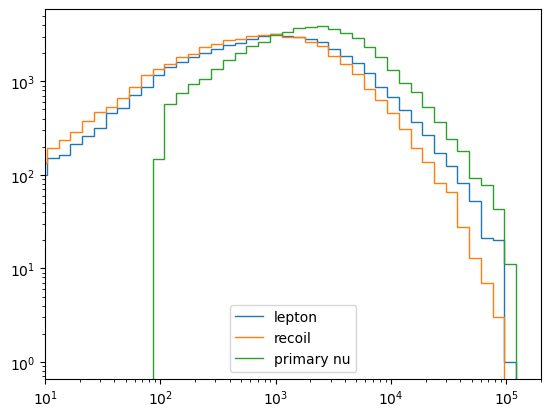

In [12]:
counts, bins = np.histogram(lepton_energies, bins=np.logspace(np.log10(1e0),np.log10(1e6), 60))
counts2, bins2 = np.histogram(HadRecoil_energies, bins=np.logspace(np.log10(1e0),np.log10(1e6), 60))
counts3, bins3 = np.histogram(primary_energies, bins=np.logspace(np.log10(1e0),np.log10(1e6), 60))
#counts, bins = np.histogram(zarray, bins=100)
plt.stairs(counts, bins, label='lepton')
plt.stairs(counts2, bins2, label='recoil')
plt.stairs(counts3, bins3, label='primary nu')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e1, 2e5)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(vertex_xarray, vertex_yarray, vertex_zarray)

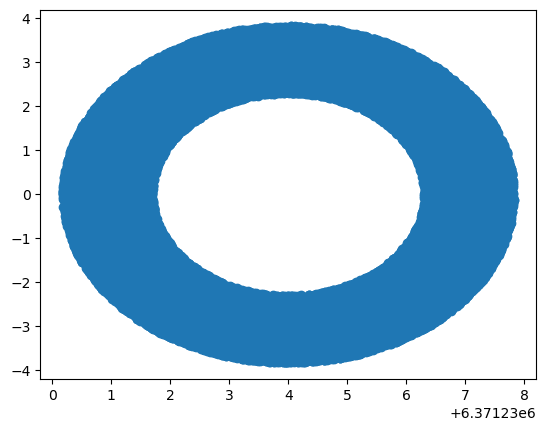

In [13]:
plt.scatter(vertex_zarray, vertex_xarray)

### Loops to process events

In [19]:
# c = 2.998e-1 #m/ns

# gamma_energy_list = []
# gamma_weight_list = []
# gamma_time_list = []

# # generate evenents in lower target
# while lower_injector.InjectedEvents() < events_to_inject:
#     print(lower_injector.InjectedEvents(),end='\r')
#     tree = lower_injector.GenerateEvent() # generate the interaction tree
#     weight = lower_weighter.EventWeight(tree) # calculate the event weight for this tree
#     time = 0
#     for datum in tree.tree: # loop over interactions in the tree
#         if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuMu):
#             # calculate travel time of speed of light neutrino
#             dist = LI.math.Vector3D(datum.record.interaction_vertex) - lower_target_origin
#             time += dist.magnitude()/c
#         if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuF4):
#             # calculate travel time of non-ultra-relativistic HNL
#             dist = LI.math.Vector3D(datum.record.interaction_vertex) - LI.math.Vector3D(datum.parent.record.interaction_vertex)
#             gamma = datum.record.primary_momentum[0]/datum.record.primary_mass
#             beta = np.sqrt(1 - (1/gamma)**2)
#             time += dist.magnitude()/(beta*c)

#             # figure out if we're in the fiducial volume
#             HNL_vtx = LI.math.Vector3D(datum.record.interaction_vertex)
#             HNL_dir = LI.math.Vector3D(datum.record.primary_momentum[1:])
#             HNL_dir.normalize()
#             if(fid_vol.IsInside(HNL_vtx,HNL_dir)):

#                 # Save the energy of the gamma
#                 for sID,sP in zip(datum.record.signature.secondary_types,
#                                   datum.record.secondary_momenta):
#                     if(sID==LI.dataclasses.Particle.ParticleType.Gamma):
#                         gamma_energy_list.append(sP[0]*1e3)
#                         gamma_weight_list.append(weight)

#     # if this is a fiducial event, save the travel time
#     if(fid_vol.IsInside(HNL_vtx,HNL_dir)):
#         gamma_time_list.append(time - 23./c)

### Post-processing and plotting

In [ ]:
# # Class for energy smearing: assumes 15% uncertainty on energy reconstruction
# class EnergySmearingGaus:
  
#     def __init__(self,gamma_energies,
#                     gamma_weights,
#                     res=0.15):
#         self.gamma_energies = gamma_energies
#         self.gamma_weights = gamma_weights
#         self.res = res

#     def Gaus(self,x,mu,std_dev):
#         return 1./np.sqrt(2*np.pi*std_dev**2)*np.exp(-(x-mu)**2/(2*std_dev**2))

#     def smeared_rate(self,E):
#         ret = 0
#         for e,w in zip(self.gamma_energies,self.gamma_weights):
#               ret += w*self.Gaus(E,e,self.res*e)
#         return(ret)

#     def smeared_rate_in_bin(self,Elow,Ehigh):
#         ret = 0
#         for e,w in zip(self.gamma_energies,self.gamma_weights):
#             ret += w/2. * (erf((Ehigh - e)/ (np.sqrt(2)*self.res*e)) - erf((Elow - e) / (np.sqrt(2)*self.res*e)))
#         return(ret)

# smear_gaus = EnergySmearingGaus(gamma_energy_list,gamma_weight_list)


# data = pd.read_csv(WorkshopToolsDir+'CCM120_Data/finalHists_all_beamShift.txt')
# print(data.keys())


# # Calculate binning in PE, convert to MeV
# blow = data['binLowEdge']
# bhigh = list(blow[1:]) + [5e3]
# data['BinLow(PE)'] = blow
# data['BinHigh(PE)'] = bhigh
# data['Bin(PE)'] = (blow+bhigh)/2.
# data['BinWidth(PE)'] = bhigh - blow
# data['BinLow(MeV)'] = data['BinLow(PE)']*pe_to_MeV
# data['BinHigh(MeV)'] = data['BinHigh(PE)']*pe_to_MeV
# data['Bin(MeV)'] = data['Bin(PE)']*pe_to_MeV
# data['bc'] = data['Bin(MeV)']
# data['BinWidth(MeV)'] = data['BinWidth(PE)']*pe_to_MeV

# # find the HNL decay to gamma rate in each bin
# gamma_rate = np.array([smear_gaus.smeared_rate_in_bin(elow,ehigh) for (elow,ehigh) in zip(data['BinLow(MeV)'],data['BinHigh(MeV)'])])


# plt.errorbar(data['Bin(MeV)'],data['DataValue']/data['BinWidth(MeV)'],
#              xerr=data['BinWidth(MeV)']/2,yerr=data['DataError']/data['BinWidth(MeV)'],
#              fmt='.',color='black',capsize=2,label='Data')
# plt.fill_between(data['BinLow(MeV)'],data['BackgroundPrediction']/data['BinWidth(MeV)'],
#                  color='red',alpha=0.5,step='post',label='Background')
# plt.fill_between(data['BinLow(MeV)'],
#                  y1=data['BackgroundPrediction']/data['BinWidth(MeV)'],
#                  y2=data['BackgroundPrediction']/data['BinWidth(MeV)'] + gamma_rate/data['BinWidth(MeV)']*CCM120_POT,
#                  color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
# plt.xlabel('Energy [MeV]')
# plt.ylabel('Events / MeV')
# plt.xlim(1,1e2)
# plt.legend(title='CCM120 %2.2e POT'%CCM120_POT)
# plt.loglog()
# plt.show()

# plt.errorbar(data['Bin(MeV)'],data['Subtraction'],
#              xerr=data['BinWidth(MeV)']/2,yerr=data['SubtractionError'],
#              fmt='.',color='black',capsize=2,label='Data')
# plt.fill_between(data['BinLow(MeV)'],
#                  gamma_rate*CCM120_POT,
#                  color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
# plt.xlabel('Energy [MeV]')
# plt.ylabel('Background-Subtrcacted Events')
# plt.xlim(1,1e2)
# plt.legend(title='CCM120 %2.2e POT'%CCM120_POT)
# plt.semilogx()
# plt.show()

# # adjustment to CCM200
# adj = CCM200_POT/CCM120_POT*bkg_reduction_factor

# plt.fill_between(data['BinLow(MeV)'],data['BackgroundPrediction']/data['BinWidth(MeV)']*adj,
#                  color='red',alpha=0.5,step='post',label='Background')
# plt.fill_between(data['BinLow(MeV)'],
#                  y1=data['BackgroundPrediction']/data['BinWidth(MeV)']*adj,
#                  y2=data['BackgroundPrediction']/data['BinWidth(MeV)']*adj + gamma_rate/data['BinWidth(MeV)']*CCM200_POT,
#                  color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
# plt.xlabel('Energy [MeV]')
# plt.ylabel('Events / MeV')
# plt.xlim(1,1e2)
# plt.legend(title='CCM200 %2.2e POT'%CCM200_POT)
# plt.loglog()
# plt.show()

# plt.fill_between(data['BinLow(MeV)'],
#                  y1=-(data['BackgroundPrediction']*adj)**(0.5),
#                  y2=(data['BackgroundPrediction']*adj)**(0.5),
#                  color='red',alpha=0.5,step='post',label='Background Stat. Unc.')
# plt.fill_between(data['BinLow(MeV)'],
#                  gamma_rate*CCM200_POT,
#                  color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
# plt.xlabel('Energy [MeV]')
# plt.ylabel('Background-Subtrcacted Events')
# plt.xlim(1,1e2)
# plt.legend(title='CCM120 %2.2e POT'%CCM200_POT,loc='lower right')
# plt.semilogx()
# plt.show()



# weights = CCM200_POT*np.array(gamma_weight_list)
# plt.hist(gamma_time_list,bins=30,weights=weights,label='%2.2f total events'%(sum(weights)))
# plt.xlabel('Gamma Time Delay [ns]')
# plt.ylabel('Number of Events in CCM')
# plt.title('HNL Mass: %s GeV; Coupling: %2.2e GeV^-1'%(hnl_mass_str,d_dipole))
# plt.legend()
# plt.tight_layout()
# plt.show()
